In [1]:
import os
import numpy as np
import pandas as pd
import pathlib 
import matplotlib.pyplot as plt
import random
from shutil import copyfile
import keras

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [5]:
isi = []
for dirname, _, filenames in os.walk('./PetImages/'):
    for filename in filenames:
        isi.append(os.path.join(dirname, filename))

isi[:5]

['./PetImages/Cat\\0.jpg',
 './PetImages/Cat\\1.jpg',
 './PetImages/Cat\\10.jpg',
 './PetImages/Cat\\100.jpg',
 './PetImages/Cat\\1000.jpg']

Jangan lupa menghapus file gambar yang sizenya terlalu kecil

In [6]:
for dirpath, dirnames, filenames in os.walk("./PetImages/"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in ./PetImages/
There are 0 directories and 12186 images in ./PetImages/Cat
There are 0 directories and 12213 images in ./PetImages/Dog


Jumlah class

In [7]:
jumlahKelas = len(os.listdir("./PetImages/"))
jumlahKelas

2

Nama class

In [11]:
data_dir = pathlib.Path("./PetImages/")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) 
print(class_names)

['Cat' 'Dog']


In [24]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split = True,  split_size=0.8):
    files = []

    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)): 
            files.append(file) 

    shuffled_files = random.sample(files,  len(files)) 
    split = int(split_size * len(shuffled_files))
    train = shuffled_files[:split] 
    split_valid_test = int(split + (len(shuffled_files)-split)/1.5)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test] 
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) 

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))
        
    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir,  element), os.path.join(test_dir, element))

    print("Split sucessful!")

In [28]:
split_data("./PetImages/Cat/", "./data/train/Cat/", "./data/validation/Cat/", "./data/test/Cat/", include_test_split=True, split_size=0.8)
split_data("./PetImages/Dog/", "./data/train/Dog/", "./data/validation/Dog/", "./data/test/Dog/", include_test_split=True, split_size=0.8)

Split sucessful!
Split sucessful!


In [29]:
print(len(os.listdir("./data/train/Cat/")))
print(len(os.listdir("./data/train/Dog/")))

print(len(os.listdir("./data/validation/Cat/")))
print(len(os.listdir("./data/validation/Dog/")))

print(len(os.listdir("./data/test/Cat/")))
print(len(os.listdir("./data/test/Dog/")))

9748
9770
1625
1628
813
815


In [2]:
train_dir = "./data/train/"
validation_dir = "./data/validation/"
test_dir = "./data/test/"

Memvisualisasikan random image

In [3]:
def plot_random_image(target_dir):
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    target_class=random.choice(os.listdir(target_dir))
    target_folder=os.path.join(target_dir,target_class)
    random_image=random.sample(os.listdir(target_folder),5)

    plt.figure(figsize=(16,5))
    for i in range(5):
        plt.subplot(1,5,i+1)
        img=tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}\n{img.shape}')
        plt.axis(False) 

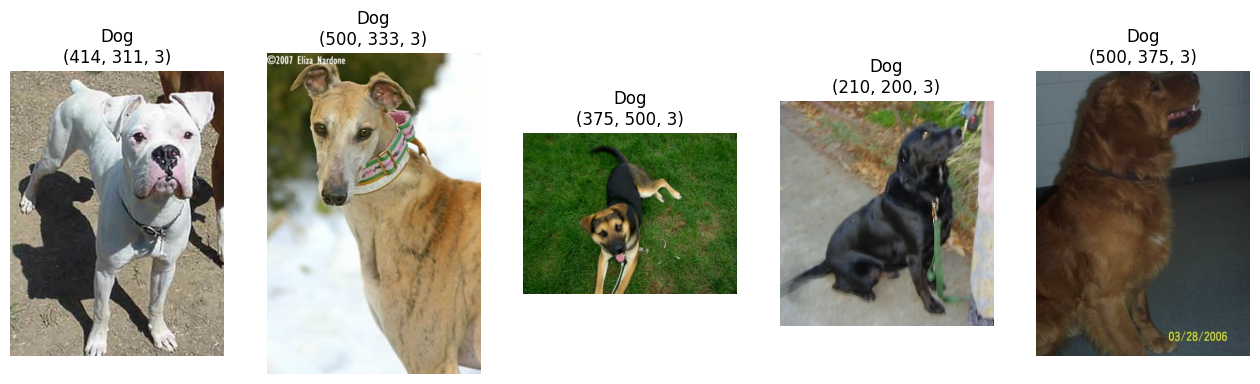

In [4]:
plot_random_image(train_dir)

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
train_data = train_datagen.flow_from_directory(
    directory = train_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary",
)

valid_data = valid_datagen.flow_from_directory(
    directory = validation_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary",
)

test_data = test_datagen.flow_from_directory(
    directory = test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary",
)

Found 19516 images belonging to 2 classes.
Found 3253 images belonging to 2 classes.
Found 1628 images belonging to 2 classes.


In [24]:
inputs5 = layers.Input(shape=(224,224,3))
x = Conv2D(32, (3,3), activation='relu')(inputs5)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Conv2D(256, (3,3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x) 

model5 = Model(inputs=inputs5, outputs=x)

In [25]:
model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [26]:
model5.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       7385

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [28]:
hist5 = model5.fit(
    train_data,
    epochs = 30,
    validation_data = valid_data,
    callbacks=[early_stopping]
)

Epoch 1/30
 87/610 [===>..........................] - ETA: 55s - loss: 0.6957 - accuracy: 0.5065

c:\Users\Nando\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


610/610 [==============================] - 82s 133ms/step - loss: 0.6857 - accuracy: 0.5422 - val_loss: 0.6407 - val_accuracy: 0.6259
Epoch 2/30
610/610 [==============================] - 68s 111ms/step - loss: 0.6166 - accuracy: 0.6655 - val_loss: 0.5550 - val_accuracy: 0.7141
Epoch 3/30
610/610 [==============================] - 71s 117ms/step - loss: 0.5613 - accuracy: 0.7117 - val_loss: 0.5394 - val_accuracy: 0.7464
Epoch 4/30
610/610 [==============================] - 70s 115ms/step - loss: 0.5043 - accuracy: 0.7585 - val_loss: 0.4700 - val_accuracy: 0.7864
Epoch 5/30
610/610 [==============================] - 67s 109ms/step - loss: 0.4503 - accuracy: 0.7954 - val_loss: 0.4255 - val_accuracy: 0.8051
Epoch 6/30
610/610 [==============================] - 69s 112ms/step - loss: 0.3848 - accuracy: 0.8304 - val_loss: 0.3540 - val_accuracy: 0.8515
Epoch 7/30
610/610 [==============================] - 71s 115ms/step - loss: 0.3171 - accuracy: 0.8652 - val_loss: 0.3264 - val_accuracy: 0.8

In [29]:
result5 = model5.evaluate(test_data)
result5

51/51 [==============================] - 6s 110ms/step - loss: 0.1880 - accuracy: 0.9140


[0.18797710537910461, 0.914004921913147]

In [30]:
val_acc_per_epoch = hist5.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 15


In [40]:
best_epoch = early_stopping.stopped_epoch - early_stopping.patience
print('The best epoch was epoch', best_epoch)

The best epoch was epoch 12


In [ ]:
def plot_loss_accuracy(history):

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize = (20,7))

    # plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = "Training Loss")
    plt.plot(epochs, val_loss, label = "Validation Loss")
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy, label = "Training Accuracy")
    plt.plot(epochs,val_accuracy, label = "Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

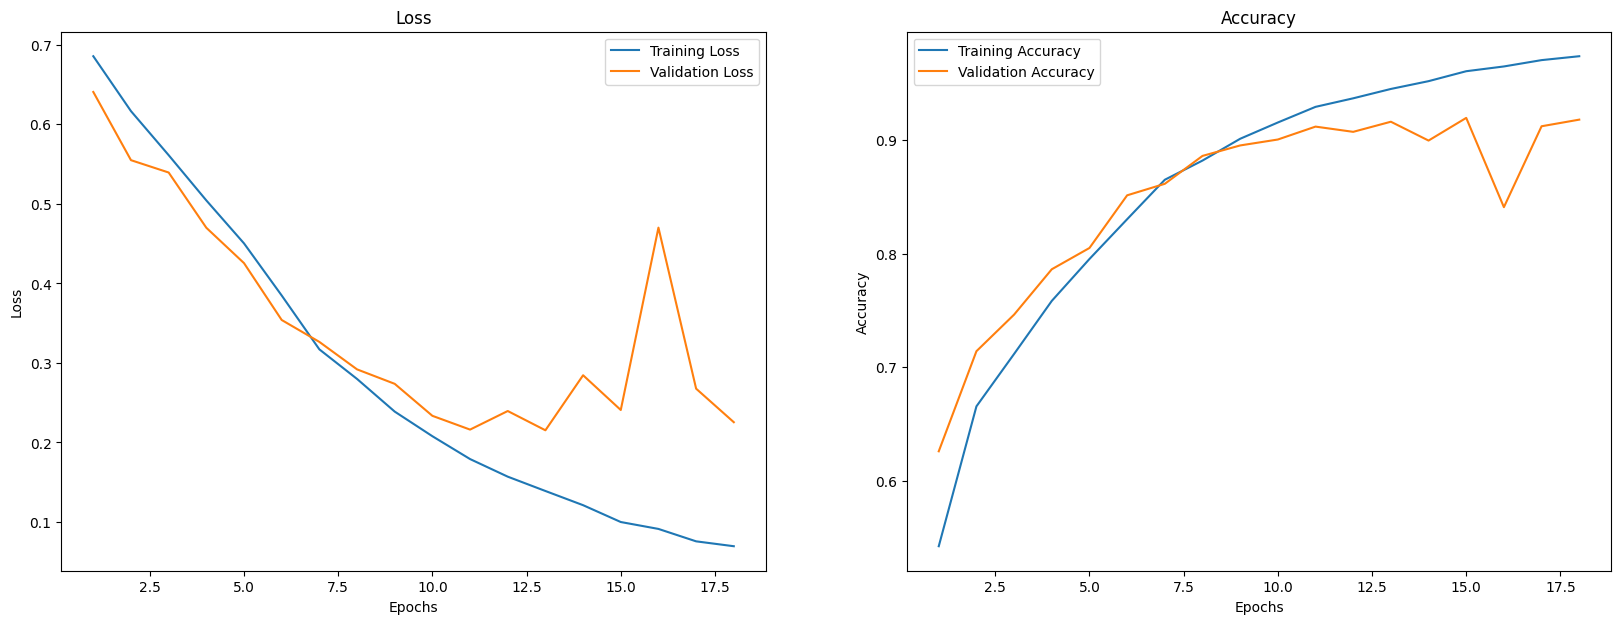

In [32]:
plot_loss_accuracy(hist5)

In [ ]:
def plot_accuracy_lost(hist):
    plt.figure(figsize=(20, 14))

    plt.subplot(2, 1, 1)
    i_train_acc = hist.history['accuracy']
    i_val_acc = hist.history['val_accuracy']
    i_epoch = [i for i in range(len(i_val_acc))]
    plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
    plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
    plt.title('Training & Validation Accuracy for InceptionV3')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.subplot(2, 1, 2)
    i_train_loss = hist.history['loss']
    i_val_loss = hist.history['val_loss']
    i_epoch = [i for i in range(len(i_val_acc))]
    plt.plot(i_epoch , i_train_loss , 'go-' , label = 'Training Loss')
    plt.plot(i_epoch , i_val_loss , 'ro-' , label = 'Validation Loss')
    plt.title('Training & Validation Loss for InceptionV3')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


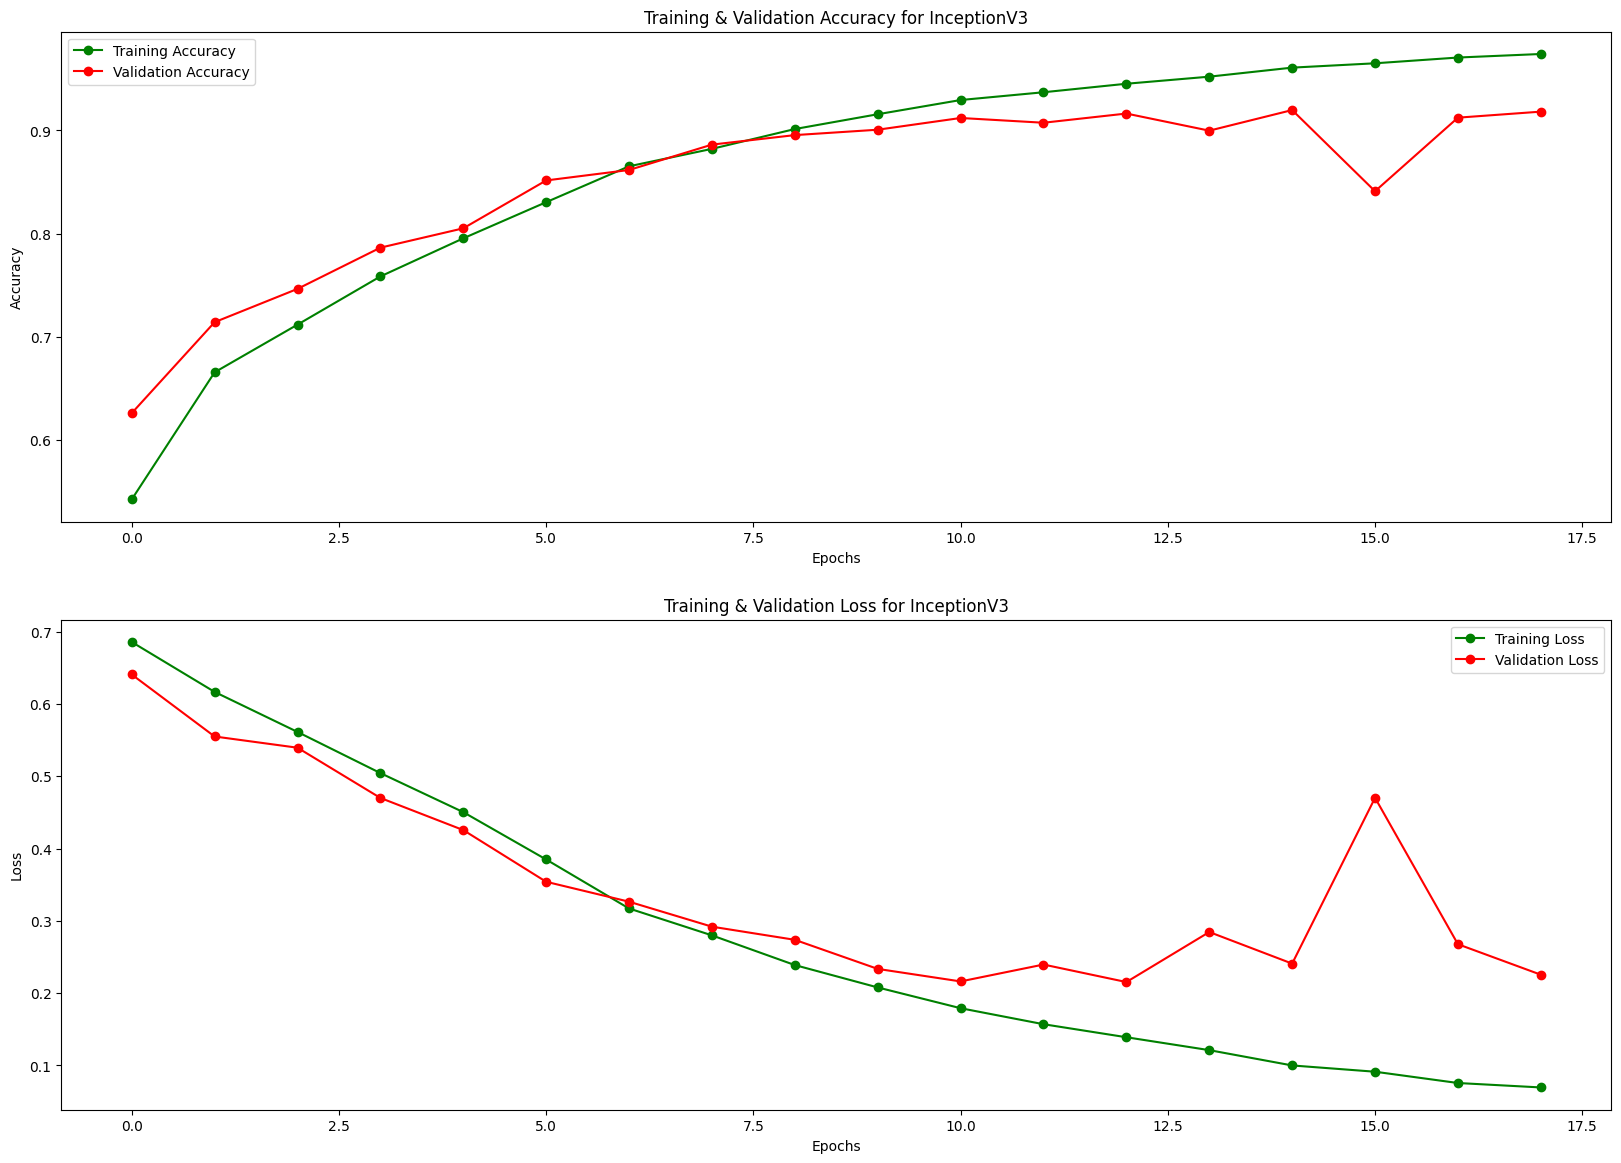

In [147]:
plot_accuracy_lost(hist5)

In [122]:
results_tabel = pd.DataFrame(hist5.history)
results_tabel.tail()

loss  accuracy  val_loss  val_accuracy
13  0.121129  0.952142  0.284514      0.899785
14  0.099957  0.960904  0.240818      0.919766
15  0.091273  0.965106  0.470129      0.841070
16  0.075663  0.970691  0.267640      0.912389
17  0.069526  0.974124  0.225471      0.918229

In [85]:
def plot_prediction(model_n, generator, n_images):
    i = 1
    images, labels = generator.next()

    preds = model_n.predict(images)
    predictions = np.argmax(preds, axis=1)
    labels = labels.astype('int32')
    
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(class_names[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break
    
    plt.show()

1/1 [==============================] - 0s 67ms/step


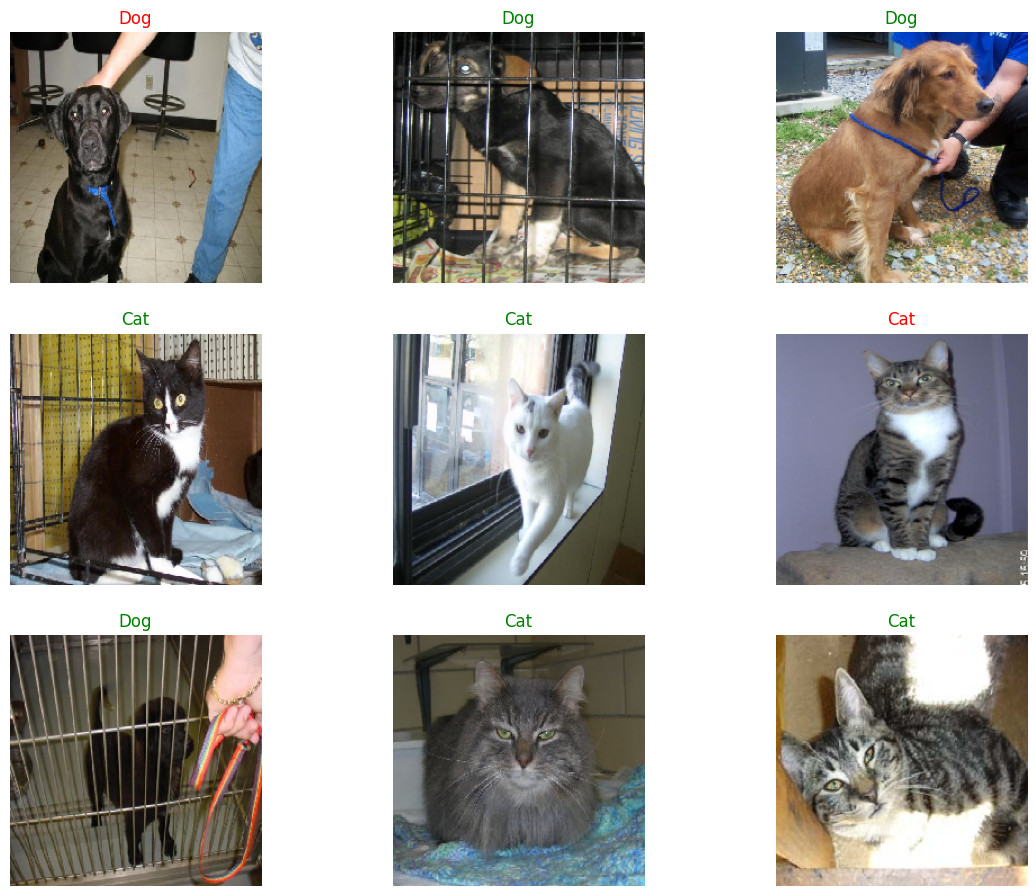

In [89]:
plot_prediction(model5, test_data, 10)

In [39]:
model5.save(os.path.join("./models", "model5.h5"))

In [76]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer
for layer in vgg.layers:
    layer.trainable = False

model7 = Sequential()
model7.add(vgg)
model7.add(Flatten())
model7.add(Dense(512, activation='relu'))
model7.add(Dense(2, activation='softmax'))

In [77]:
model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [78]:
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_31 (Dense)            (None, 512)               12845568  
                                                                 
 dense_32 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 27,561,282
Trainable params: 12,846,594
Non-trainable params: 14,714,688
_________________________________________________________________


In [80]:
hist7 = model7.fit(
    train_data,
    epochs = 30,
    validation_data = valid_data,
    callbacks=[early_stopping]
)

Epoch 1/30
610/610 [==============================] - 163s 254ms/step - loss: 0.3352 - accuracy: 0.8976 - val_loss: 0.1839 - val_accuracy: 0.9293
Epoch 2/30
610/610 [==============================] - 134s 220ms/step - loss: 0.1243 - accuracy: 0.9506 - val_loss: 0.1859 - val_accuracy: 0.9225
Epoch 3/30
610/610 [==============================] - 136s 223ms/step - loss: 0.1017 - accuracy: 0.9615 - val_loss: 0.2112 - val_accuracy: 0.9253
Epoch 4/30
610/610 [==============================] - 135s 221ms/step - loss: 0.0802 - accuracy: 0.9685 - val_loss: 0.2160 - val_accuracy: 0.9268
Epoch 5/30
610/610 [==============================] - 138s 226ms/step - loss: 0.0646 - accuracy: 0.9744 - val_loss: 0.2091 - val_accuracy: 0.9268
Epoch 6/30
610/610 [==============================] - 139s 228ms/step - loss: 0.0516 - accuracy: 0.9806 - val_loss: 0.2483 - val_accuracy: 0.9271


In [81]:
result7 = model7.evaluate(test_data)
result7

51/51 [==============================] - 9s 179ms/step - loss: 0.1768 - accuracy: 0.9220


[0.1767910122871399, 0.921990156173706]

In [82]:
val_acc_per_epoch = hist7.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 1


In [83]:
best_epoch = early_stopping.stopped_epoch - early_stopping.patience
print('The best epoch was epoch', best_epoch)

The best epoch was epoch 0


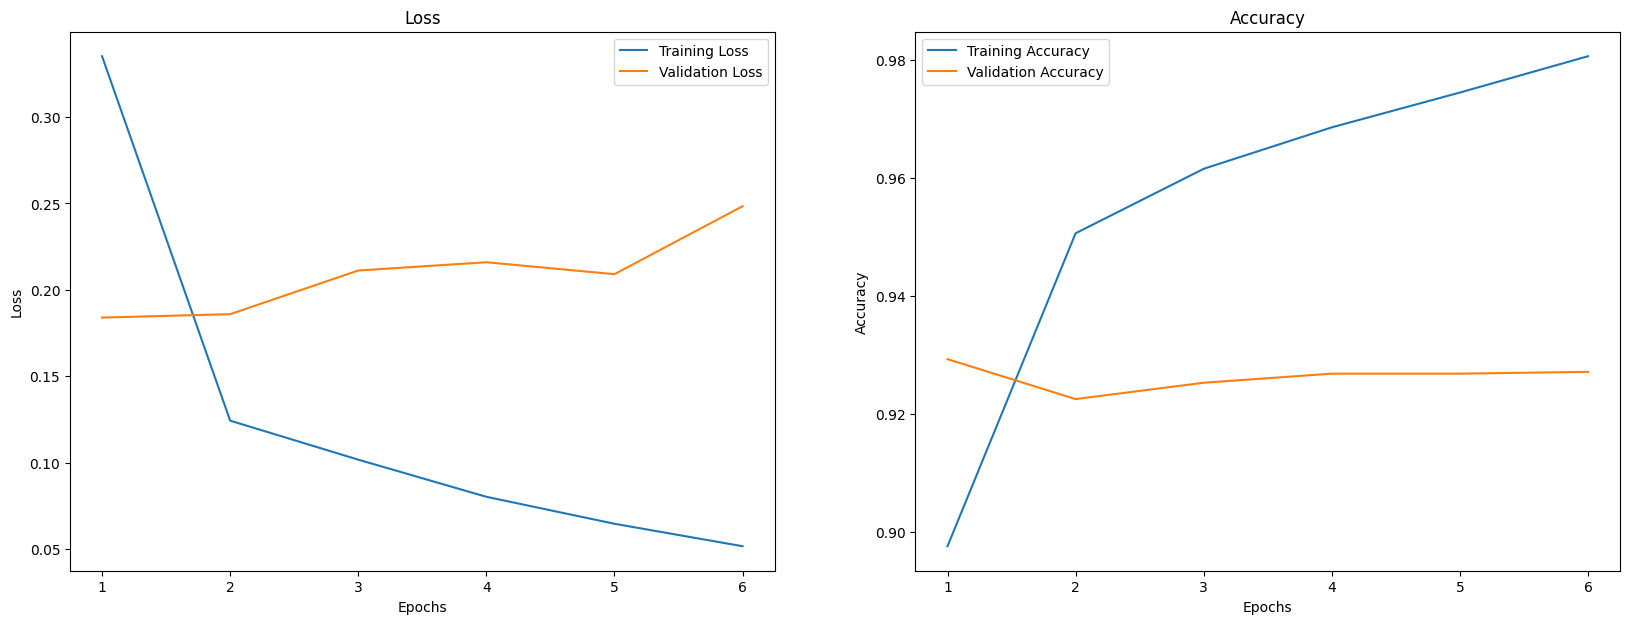

In [84]:
plot_loss_accuracy(hist7)

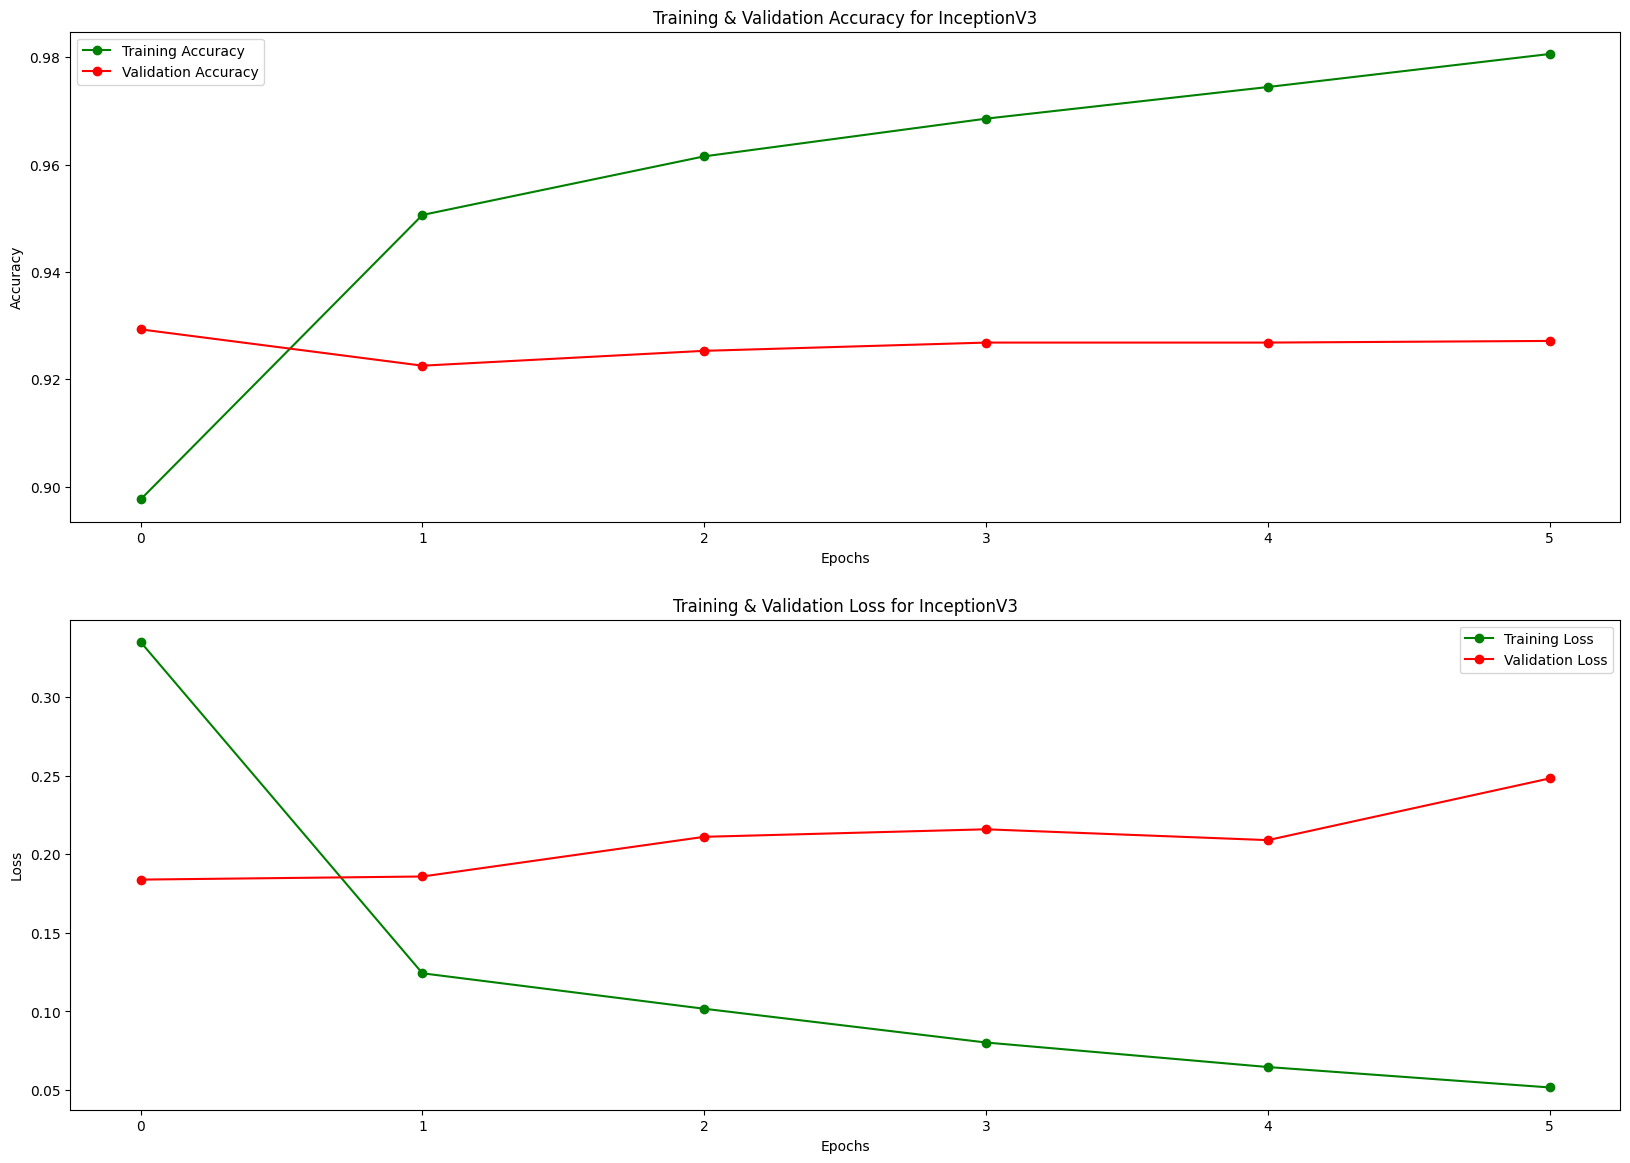

In [145]:
plot_accuracy_lost(hist7)

In [120]:
results_tabel = pd.DataFrame(hist7.history)
results_tabel.tail()

loss  accuracy  val_loss  val_accuracy
1  0.124287  0.950605  0.185903      0.922533
2  0.101713  0.961519  0.211166      0.925300
3  0.080222  0.968539  0.215951      0.926837
4  0.064613  0.974431  0.209054      0.926837
5  0.051617  0.980580  0.248349      0.927144

1/1 [==============================] - 0s 191ms/step


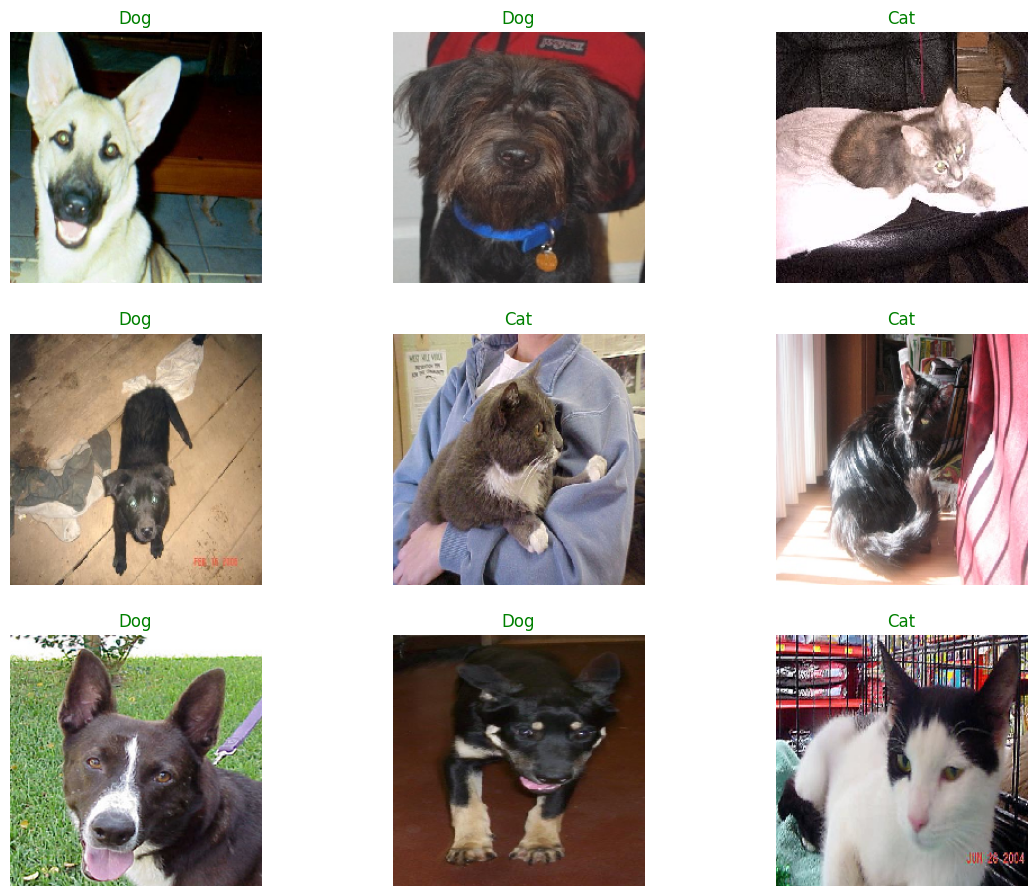

In [86]:
plot_prediction(model7, test_data, 10)

In [87]:
model7.save(os.path.join("./models", "vgg.h5"))

In [108]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer
for layer in inception.layers:
    layer.trainable = False

model9 = Sequential()
model9.add(inception)
model9.add(Flatten())
model9.add(Dense(512, activation='relu'))
model9.add(Dense(10, activation='softmax'))

In [109]:
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [110]:
model9.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_4 (Flatten)         (None, 51200)             0         
                                                                 
 dense_39 (Dense)            (None, 512)               26214912  
                                                                 
 dense_40 (Dense)            (None, 10)                5130      
                                                                 
Total params: 48,022,826
Trainable params: 26,220,042
Non-trainable params: 21,802,784
_________________________________________________________________


In [111]:
hist9 = model9.fit(
    train_data,
    epochs = 6,
    validation_data = valid_data,
)

Epoch 1/6
429/610 [====================>.........] - ETA: 15s - loss: 1.5020 - accuracy: 0.9730

c:\Users\Nando\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


610/610 [==============================] - 67s 102ms/step - loss: 1.1918 - accuracy: 0.9758 - val_loss: 0.1081 - val_accuracy: 0.9880
Epoch 2/6
610/610 [==============================] - 63s 103ms/step - loss: 0.0595 - accuracy: 0.9922 - val_loss: 0.0561 - val_accuracy: 0.9883
Epoch 3/6
610/610 [==============================] - 63s 103ms/step - loss: 0.0127 - accuracy: 0.9955 - val_loss: 0.0529 - val_accuracy: 0.9889
Epoch 4/6
610/610 [==============================] - 63s 103ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0403 - val_accuracy: 0.9883
Epoch 5/6
610/610 [==============================] - 65s 107ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0631 - val_accuracy: 0.9877
Epoch 6/6
610/610 [==============================] - 65s 107ms/step - loss: 6.5026e-04 - accuracy: 0.9998 - val_loss: 0.0573 - val_accuracy: 0.9886


In [112]:
result9 = model9.evaluate(test_data)
result9

51/51 [==============================] - 5s 88ms/step - loss: 0.0659 - accuracy: 0.9883


[0.06592096388339996, 0.9883292317390442]

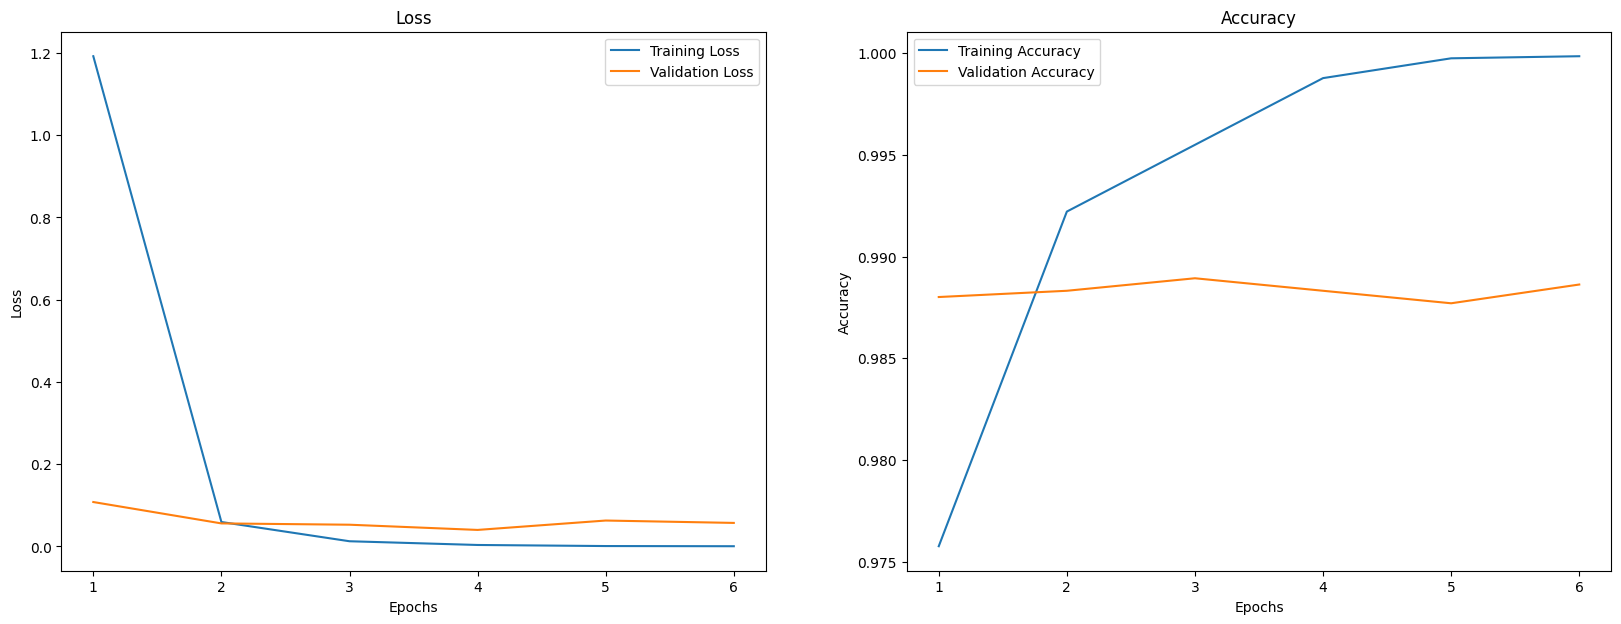

In [113]:
plot_loss_accuracy(hist9)

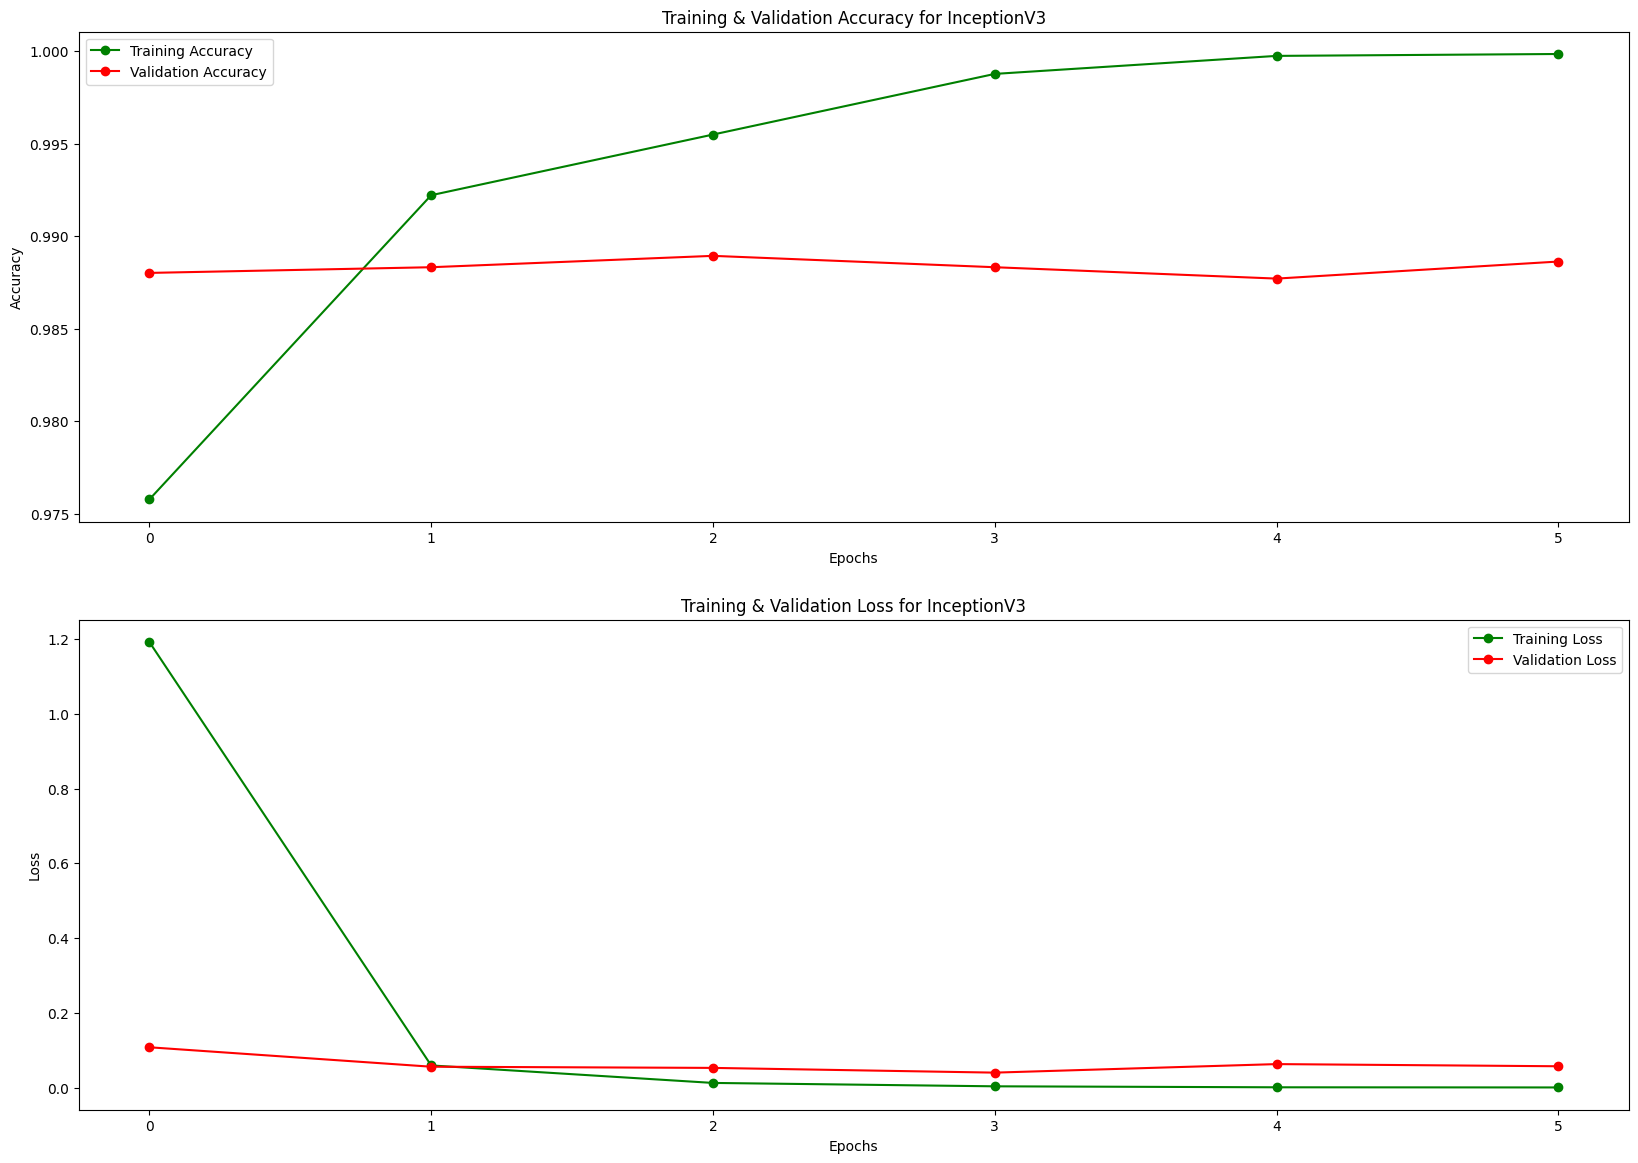

In [143]:
plot_accuracy_lost(hist9)

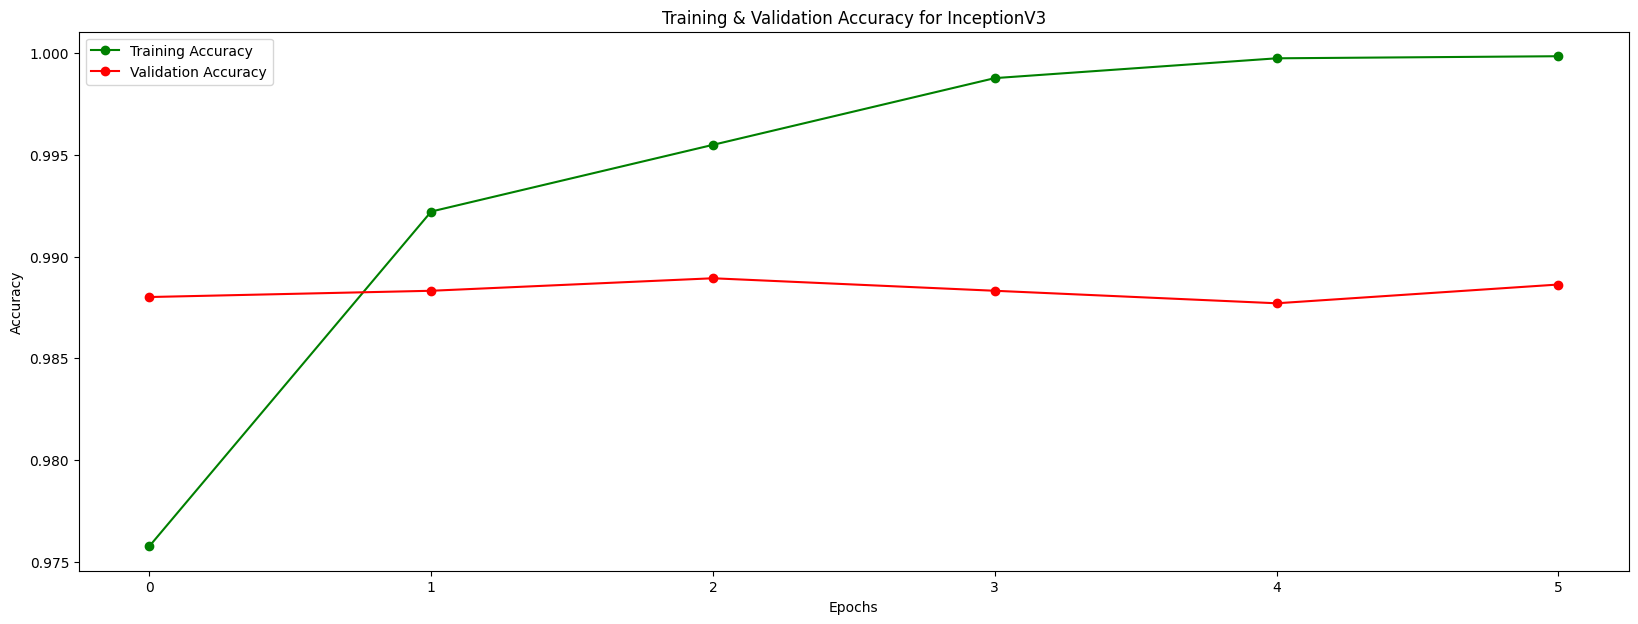

In [139]:
plt.figure(figsize=(20, 7))
i_train_acc = hist9.history['accuracy']
i_val_acc = hist9.history['val_accuracy']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for InceptionV3')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [118]:
results_tabel = pd.DataFrame(hist9.history)
results_tabel.tail()

loss  accuracy  val_loss  val_accuracy
1  0.059516  0.992212  0.056105      0.988319
2  0.012734  0.995491  0.052930      0.988933
3  0.003683  0.998770  0.040278      0.988319
4  0.001067  0.999744  0.063094      0.987704
5  0.000650  0.999846  0.057313      0.988626

1/1 [==============================] - 0s 56ms/step


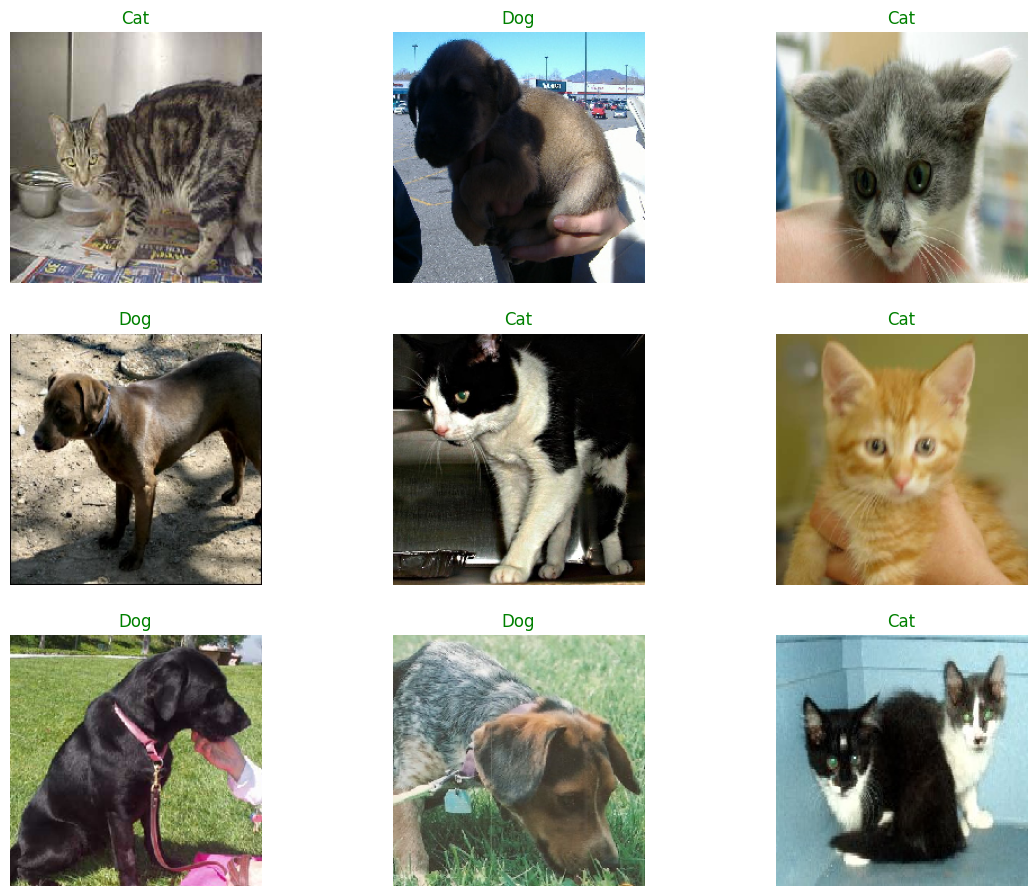

In [116]:
plot_prediction(model9, test_data, 10)

In [115]:
model9.save(os.path.join("./models", "inceptionV3.h5"))

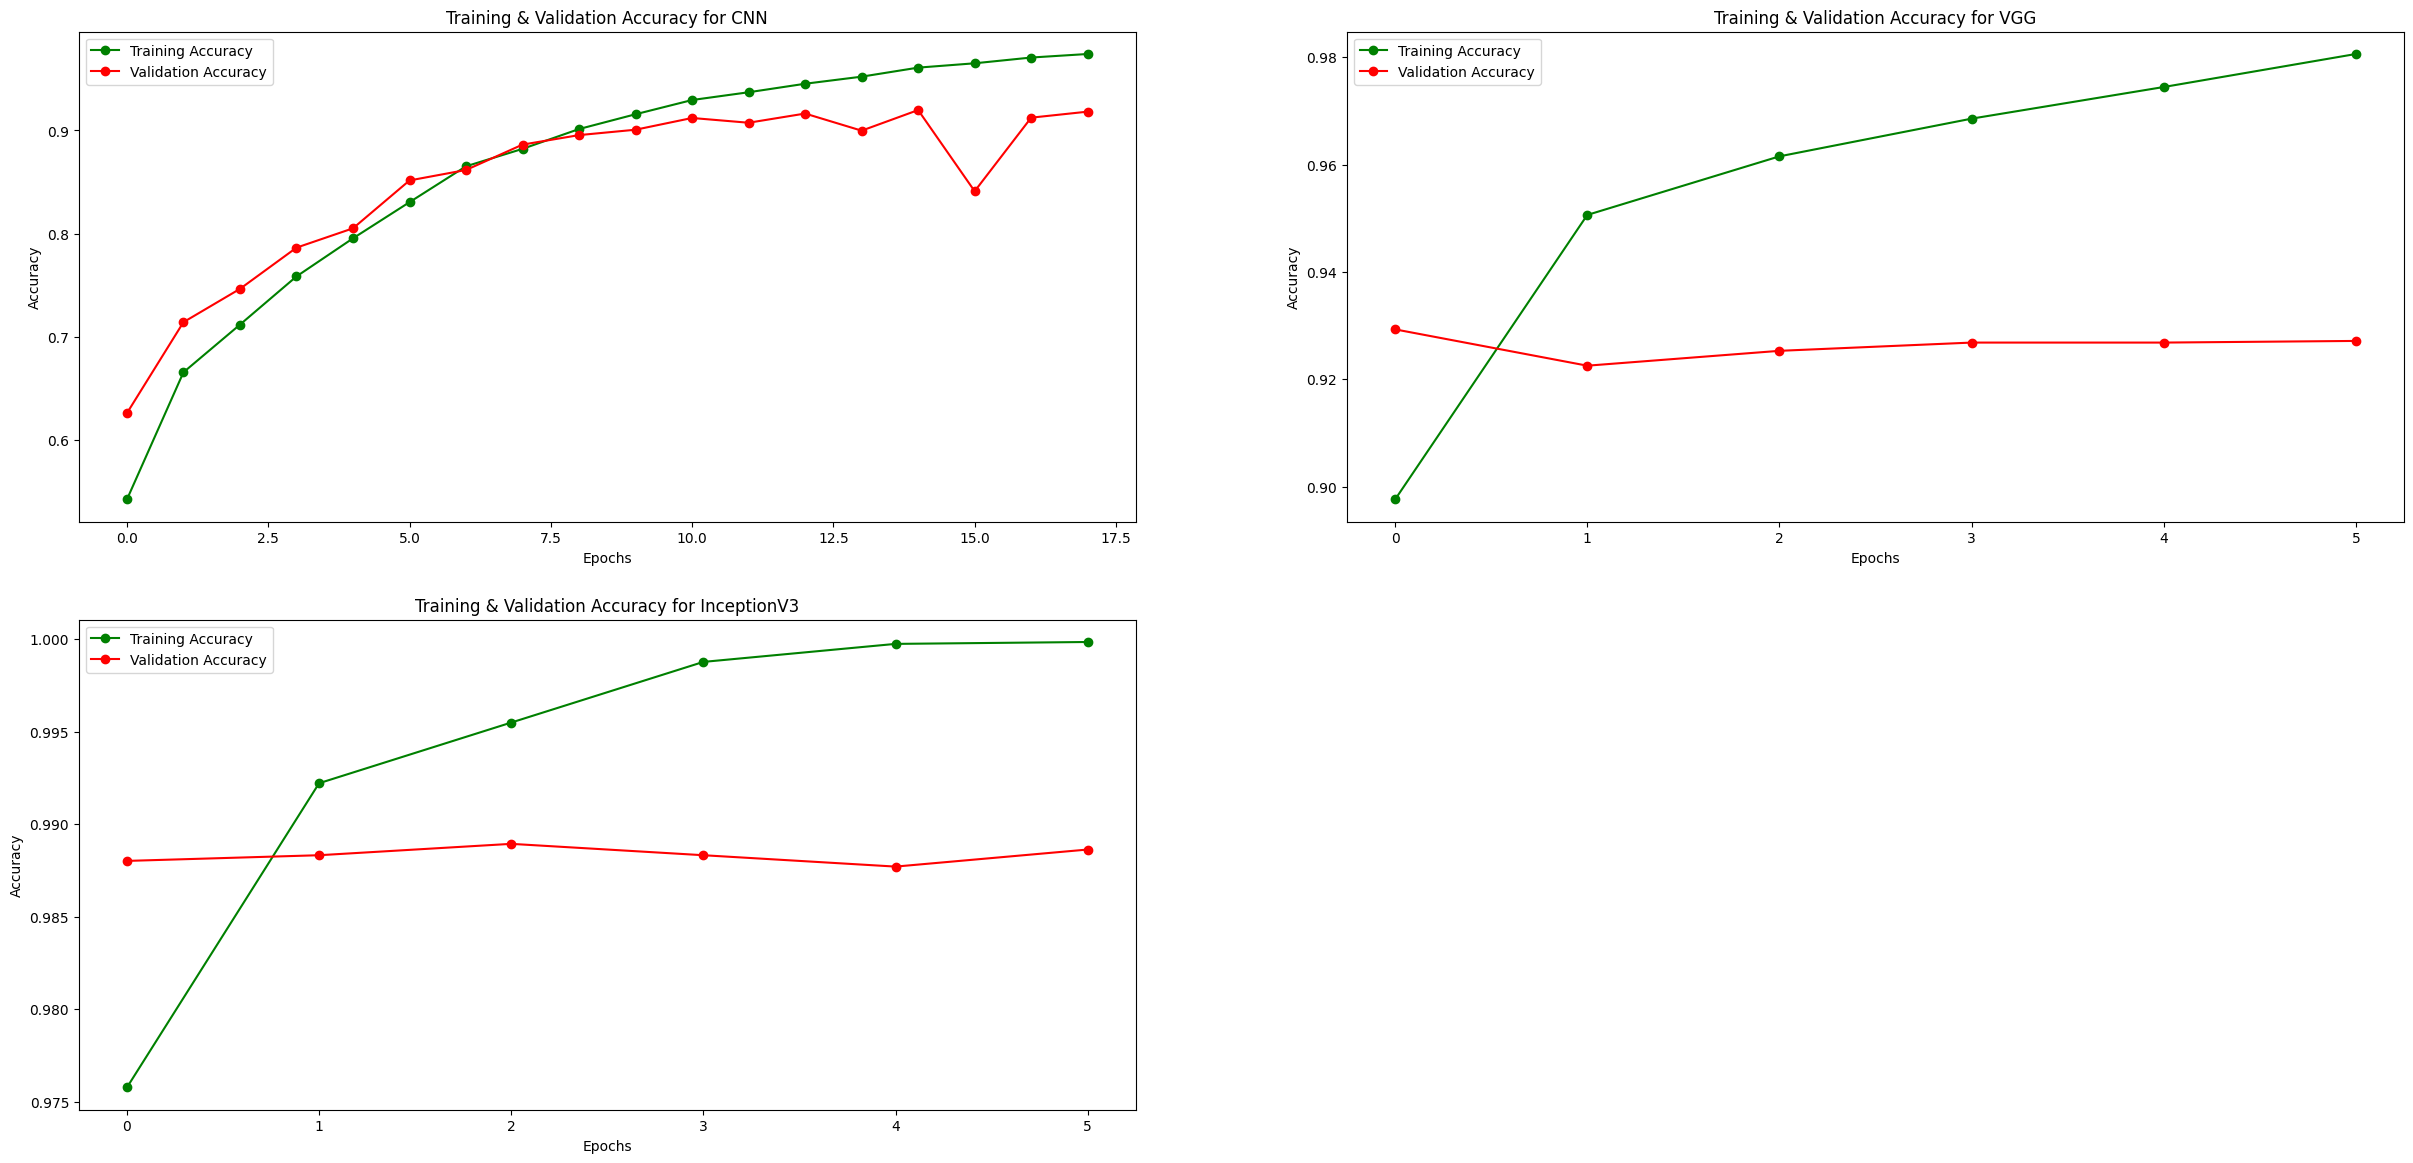

In [149]:
plt.figure(figsize = (30,14))

plt.subplot(2,2,1)
i_train_acc = hist5.history['accuracy']
i_val_acc = hist5.history['val_accuracy']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for CNN')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,2)
x_train_acc = hist7.history['accuracy']
x_val_acc = hist7.history['val_accuracy']
x_epoch = [i for i in range(len(x_val_acc))]
plt.plot(x_epoch , x_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(x_epoch , x_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for VGG')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.subplot(2,2,3)
x_train_acc = hist9.history['accuracy']
x_val_acc = hist9.history['val_accuracy']
x_epoch = [i for i in range(len(x_val_acc))]
plt.plot(x_epoch , x_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(x_epoch , x_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy for InceptionV3')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()